## Анализ и прогнозирование временных рядов методами искусственного интеллекта

### **Практическая работа 3. Поиск аномалий во временных рядах.**


#### **3.1 Поиск диссонансов с помощью алгоритма HotSAX**

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!pip install saxpy

In [34]:
!pip install scipy
!pip install scikit-learn

##### *Краткое описание*

##### 3.1.1 Загрузка и подготовка данных

В данной будет использоваться временной ряд, состоящий из показаний акселерометра.
Анализируемый временной ряд, описывает две активности человека - бег и шг
.


In [10]:
import numpy as np
from saxpy.znorm import znorm
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from time import time

In [26]:
#fixme: Путь
data_path = Path('dataset')/'/content/drive/MyDrive/2023-Sysoeva-TimeSeriesCourse/practice/03 Discords/dataset/walk_run.txt'
data = np.loadtxt(data_path)[3000:4000]
size_sub = 50

In [30]:
#fixme: Путь
dataset_dir_path = Path('datasets')
data_path = dataset_dir_path/'/content/drive/MyDrive/2023-Sysoeva-TimeSeriesCourse/practice/03 Discords/dataset/walk_run.txt'
walk_run = np.loadtxt(data_path)[3000:4000]
data = walk_run
size_sub = 50

In [31]:
data

array([ 3.1991567e+00,  3.2663387e+00,  3.4749122e+00,  3.3734364e+00,
        3.4144765e+00,  3.3085032e+00,  2.2233591e+00,  6.1512298e-01,
        2.5913141e+00,  3.7827126e+00,  3.6342937e+00,  1.2977653e+00,
        5.0288124e-01, -6.5450457e-01, -1.1348138e+00, -1.9791427e+00,
       -2.9200281e+00, -3.6154603e+00, -4.1531975e+00, -4.6400562e+00,
       -4.9610682e+00, -5.2148981e+00, -5.6888264e+00, -5.9558679e+00,
       -5.8153197e+00, -5.4046381e+00, -4.5593816e+00, -3.4411806e+00,
       -2.7946311e+00, -3.3517920e+00, -1.7953338e+00, -5.3332396e-02,
        1.1584821e+00,  3.2823612e+00,  2.5853830e+00,  3.9628953e+00,
        4.3564301e+00,  4.0950105e+00,  4.1290232e+00,  3.6185524e+00,
        2.6853127e+00,  2.0613352e+00,  1.9735488e+00,  2.1459452e+00,
        2.2495292e+00,  2.3224455e+00,  2.1893465e+00,  1.8895292e+00,
        1.6214758e+00,  1.6517498e+00,  1.6503725e+00,  1.6676599e+00,
        1.5288826e+00,  1.3738580e+00,  1.2168658e+00,  1.0960225e+00,
      

В середине временного ряда происходит смена активности (бег заменяет шаг). Нетипичным поведением, которое мы могли бы назвать диссонансами в данном ряде выступает небольшой участок между активностями, когда человек плавно увеличивает скорость шага до бега. В ходе данной работе наша задача выделить с помощью различных алгоритмов границы нашего диссонанса.

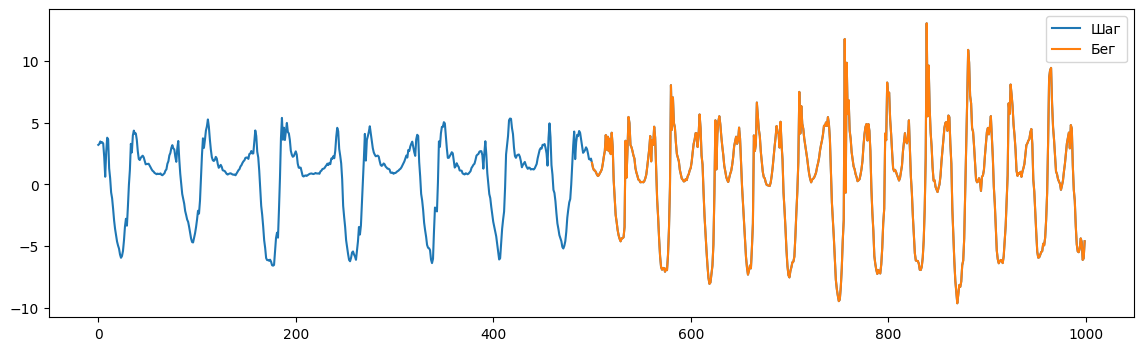

In [ ]:
fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(data[:],label='Шаг')
plt.plot(np.arange(data.shape[0]//2,data.shape[0]),data[data.shape[0]//2:],label='Бег')
plt.legend()

##### 3.1.2 Реализация перебором

Приводится пример кода для нахождения топ 5 диссонансов с помощью реализация перебором.
Вам необходимо добавить код для сбора времени обработки данных.

In [ ]:
from saxpy.discord import find_discords_brute_force

start = time()
discords_brute_force = np.stack(find_discords_brute_force(data[:], win_size=size_sub, num_discords=5))
end = time()

print(end - start)
discords_brute_force

358.39262795448303


array([[477.        ,   5.88100934],
       [412.        ,   5.32704317],
       [195.        ,   3.39426635],
       [577.        ,   3.35554403],
       [278.        ,   3.10959389]])

In [ ]:
times

{'brute_force': 358.1174581050873}

In [ ]:
discords_brute_force

array([[477.        ,   5.88100934],
       [412.        ,   5.32704317],
       [195.        ,   3.39426635],
       [577.        ,   3.35554403],
       [278.        ,   3.10959389]])

##### 3.1.3 HotSAX

Последовательный алгоритм **HOTSAX**  поиска диссонансов использует кодирование временного ряда с помощью техники символьной агрегатной аппроксимации (Symbolic Aggregate ApproXimation,
SAX) [16] и евклидово расстояние в качестве меры схожести .

Алгоритм осуществляет перебор всех пар
подпоследовательностей ряда, вычисляя евклидово расстояние между ними, и находит максимум среди
расстояний до ближайшего соседа. **Подпоследовательность с максимальным расстоянием до ближайшего соседа является** **диссонансом**. При переборе бесперспективные подпоследовательности (заведомо не
являющиеся диссонансами) отбрасываются без вычисления расстояний. **Бесперспективными** являются
подпоследовательности, которые имеют соседа, расположенного ближе текущего максимума расстояний
до всех ближайших соседей. HOTSAX осуществляет перебор в соответствии с определенной эвристикой,
которая позволяет отбрасывать больше бесперспективных кандидатов

Используя [реализацию](https://github.com/seninp/saxpy/blob/master/saxpy/hotsax.py) найдите топ 5 диссонансов ряда.
Произведите замер времени работы.

In [11]:
#Implements HOT-SAX.
import numpy as np
from saxpy.znorm import znorm
from saxpy.sax import sax_via_window
from saxpy.distance import euclidean


def find_discords_hotsax(series, win_size=100, num_discords=2, alphabet_size=3,
                         paa_size=3, znorm_threshold=0.01, sax_type='unidim'):
    """Обнаружение разногласий на основе HOT-SAX."""
    discords = list()

    global_registry = set()

    # Z-нормализованные версии для каждой подпоследовательности.
    znorms = np.array([znorm(series[pos: pos + win_size], znorm_threshold) for pos in range(len(series) - win_size + 1)])

    # Слова SAX для каждой подпоследовательности.
    sax_data = sax_via_window(series, win_size=win_size, paa_size=paa_size, alphabet_size=alphabet_size,
                              nr_strategy=None, znorm_threshold=0.01, sax_type=sax_type)

    """[2.0] построить «волшебный» массив"""
    magic_array = list()
    for k, v in sax_data.items():
        magic_array.append((k, len(v)))

    """[2.1] отсортировать по возрастанию по количеству вхожденийs"""
    magic_array = sorted(magic_array, key=lambda tup: tup[1])

    while len(discords) < num_discords:

        best_discord = find_best_discord_hotsax(series, win_size, global_registry, sax_data, magic_array, znorms)

        if -1 == best_discord[0]:
            break

        discords.append(best_discord)

        mark_start = max(0, best_discord[0] - win_size + 1)
        mark_end = best_discord[0] + win_size

        for i in range(mark_start, mark_end):
            global_registry.add(i)

    return discords


def find_best_discord_hotsax(series, win_size, global_registry, sax_data, magic_array, znorms):
    """Найдите лучший дискорд с помощью hotsax."""

    """[3.0] определить ключевые переменные"""
    best_so_far_position = -1
    best_so_far_distance = 0.

    distance_calls = 0

    visit_array = np.zeros(len(series), dtype=np.int)

    """[4.0] и мы прекращаем перебор записей магического массива"""
    for entry in magic_array:

        """[5.0] текущие слова SAX и количество других последовательностей, сопоставленных с тем же словом SAX."""
        curr_word = entry[0]
        occurrences = sax_data[curr_word]

        """[6.0] проходя по одним и тем же вхождениям слов, легче
        зафиксировать, возможно, небольшое значение расстояния, чтобы мы могли работать эффективно
        и т.д...."""
        for curr_pos in occurrences:

            if curr_pos in global_registry:
                continue

            """[7.0] нам не нужна перекрывающаяся подпоследовательность"""
            mark_start = curr_pos - win_size + 1
            mark_end = curr_pos + win_size
            visit_set = set(range(mark_start, mark_end))

            """[8.0] вот наша подпоследовательность, о которой идет речь"""
            cur_seq = znorms[curr_pos]

            """[9.0] давайте посмотрим, что такое расстояние NN"""
            nn_dist = np.inf
            do_random_search = True

            """[10.0] упорядочен по вхождениям, искать в первую очередь"""
            for next_pos in occurrences:

                """[11.0] пропустить плохое сообщение"""
                if next_pos in visit_set:
                    continue
                else:
                    visit_set.add(next_pos)

                """[12.0] расстояние, которое мы вычисляем"""

                dist = euclidean(cur_seq, znorms[next_pos])
                distance_calls += 1

                """[13.0] поддерживать книги в актуальном состоянии"""
                if dist < nn_dist:
                    nn_dist = dist
                if dist < best_so_far_distance:
                    do_random_search = False
                    break

            """[13.0] если не сломано выше,
            мы продолжим случайный поиск"""
            if do_random_search:
                """[14.0] построить этот массив случайных заказов на посещение"""
                curr_idx = 0
                for i in range(0, (len(series) - win_size + 1)):
                    if not(i in visit_set):
                        visit_array[curr_idx] = i
                        curr_idx += 1
                it_order = np.random.permutation(visit_array[0:curr_idx])
                curr_idx -= 1

                """[15.0] и пойти наугад"""
                while curr_idx >= 0:
                    rand_pos = it_order[curr_idx]
                    curr_idx -= 1

                    dist = euclidean(cur_seq, znorms[rand_pos])
                    distance_calls += 1

                    """[16.0] поддерживать книги в актуальном состоянии снова"""
                    if dist < nn_dist:
                        nn_dist = dist
                    if dist < best_so_far_distance:
                        nn_dist = dist
                        break

            """[17.0] и БОЛЬШИЕ книги"""
            if (nn_dist > best_so_far_distance) and (nn_dist < np.inf):
                best_so_far_distance = nn_dist
                best_so_far_position = curr_pos

    return best_so_far_position, best_so_far_distance


**SAX (англ. «Simple API for XML»)** — способ последовательного чтения/записи XML-файлов. Обычно SAX-парсеры требуют фиксированного количества памяти для своей работы, но не позволяют изменять содержимое документа.

In [ ]:
from saxpy.hotsax import find_discords_hotsax

start = time()
discords_hotsax = find_discords_hotsax(data[:], num_discords=5, win_size=size_sub)
end = time()

print(end - start, '\n')
discords_hotsax

10.82897162437439 



[(477, 5.881009341683914),
 (412, 5.327043167878002),
 (195, 3.394266347302333),
 (577, 3.3555440274836608),
 (278, 3.10959388763498)]

##### 3.1.4 Визаулизация

Вам необходимо реализовать код позволяющий:
1. Вывести на одном графике ряд и его диссонансы
2. Столбчатую диаграмму времени работы
   
Постройте графики для обоих алгоритмов и сравните полученные результаты. Сделайте выводы

In [ ]:
from matplotlib.patches import Rectangle

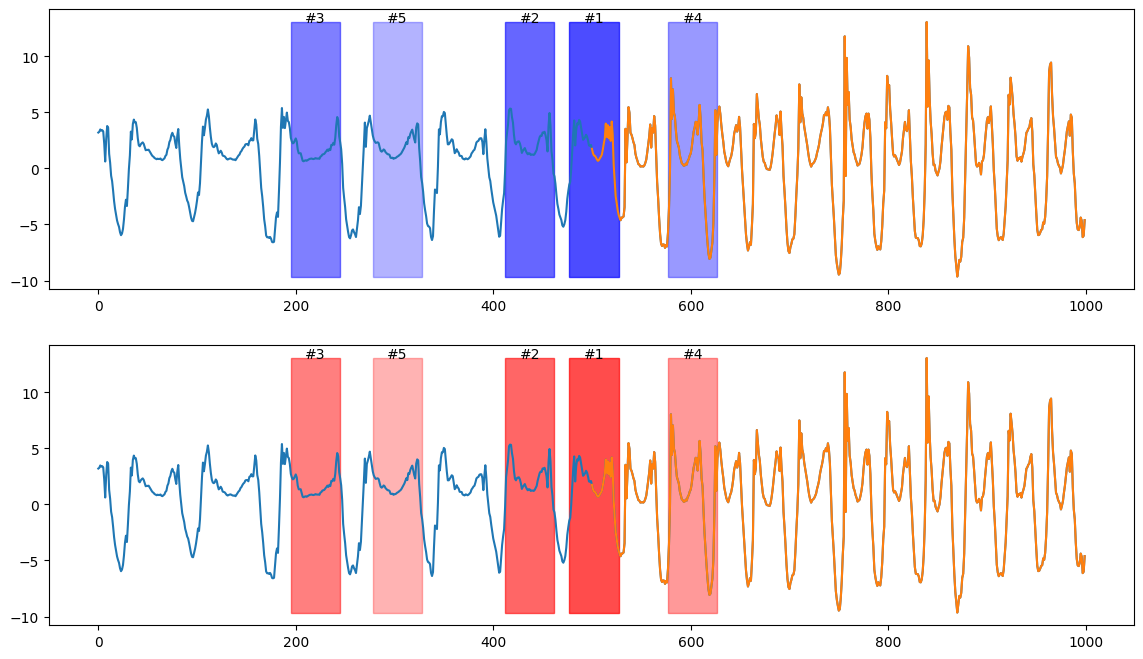

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
ax1.label = 'brute force'
ax2.label = 'hotsax'
mn, mx = min(data), max(data)

for i in range(len(discords_brute_force)):
    alpha = 1-(i+3)*0.1
    ax1.add_patch(Rectangle(xy=(discords_brute_force[i][0], mn), width=size_sub, height=mx-mn, color='blue', alpha=alpha))
    ax1.text(discords_brute_force[i][0]+size_sub/2, mx, f"#{i+1}", ha='center')
ax1.plot(data[:], label='Шаг')
ax1.plot(np.arange(data.shape[0]//2, data.shape[0]), data[data.shape[0]//2:], label='Бег')

for i in range(len(discords_hotsax)):
    alpha = 1-(i+3)*0.1
    ax2.add_patch(Rectangle(xy=(discords_hotsax[i][0], mn), width=size_sub, height=mx-mn, color='red', alpha=alpha))
    ax2.text(discords_hotsax[i][0]+size_sub/2, mx, f"#{i+1}", ha='center')
ax2.plot(data[:], label='Шаг')
ax2.plot(np.arange(data.shape[0]//2, data.shape[0]), data[data.shape[0]//2:], label='Бег')

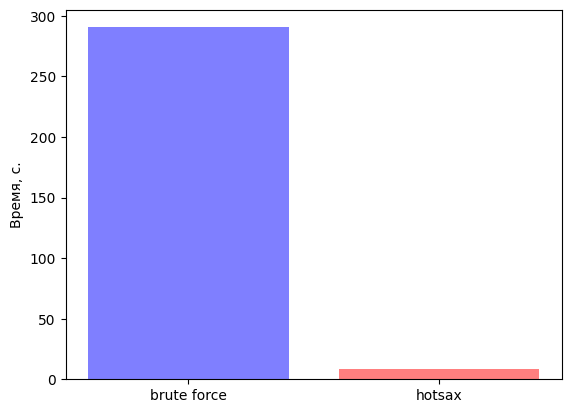

In [ ]:
fig, ax = plt.subplots()
ax.bar(['brute force', 'hotsax'], [290.58384823799133, 8.51403546333313], color=['blue', 'red'], alpha=0.5)
ax.set_ylabel('Время, с.');

##### 3.1.5 Такси NY

Произведите поиск диссонансов с помощью обоих алгоритмов на наборе данных, содержащим информацию о среднем числе пассажиров в NY. Отобразите найденные диссонансы обоими алгоритмами.

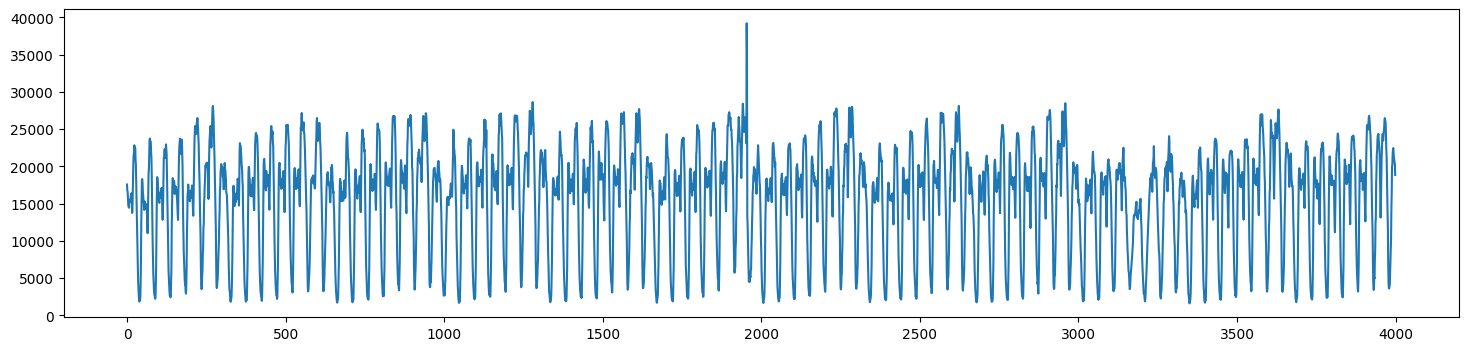

In [45]:
import pandas as pd

nyc_taxi = pd.read_csv('/content/drive/MyDrive/2023-Sysoeva-TimeSeriesCourse/practice/03 Discords/dataset/nyc_taxi.csv', index_col=0).values[4000:8000, 0].astype(np.float64)
fig = plt.figure(figsize=(18, 4))
plt.plot(nyc_taxi)

In [ ]:
nyc_taxi

array([17569., 16738., 16612., ..., 20577., 20293., 18839.])

In [ ]:
#discords_brute_force = np.stack(find_discords_brute_force(nyc_taxi[:], win_size=size_sub, num_discords=5))
discords_brute_force = find_discords_brute_force(nyc_taxi[:], win_size=size_sub, num_discords=1) # 27 min seconds


In [ ]:
discords_hotsax = find_discords_hotsax(nyc_taxi[:], num_discords=5, win_size=size_sub) # 38 seconds

In [ ]:
discords_hotsax

[(1910, 3.5268153024066273),
 (3120, 3.402331642708897),
 (3183, 2.642040969754124),
 (3241, 2.3031722503565266),
 (963, 1.6115276543785828)]

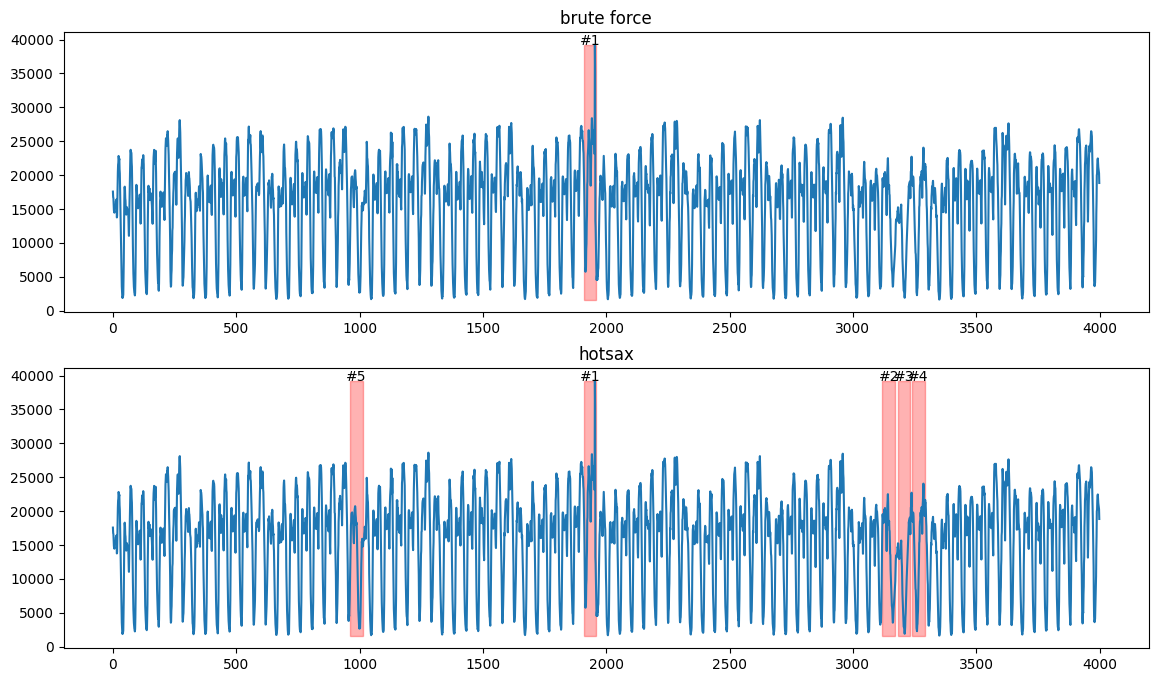

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
ax1.set_title('brute force')
ax2.set_title('hotsax')
mn, mx = min(nyc_taxi), max(nyc_taxi)

for i in range(len(discords_brute_force)):
    alpha = 0.3
    ax1.add_patch(Rectangle(xy=(discords_brute_force[i][0], mn), width=size_sub, height=mx-mn, color='red', alpha=alpha))
    ax1.text(discords_brute_force[i][0]+size_sub/2, mx, f"#{i+1}", ha='center')
ax1.plot(nyc_taxi)

for i in range(len(discords_hotsax)):
    alpha = 0.3
    ax2.add_patch(Rectangle(xy=(discords_hotsax[i][0], mn), width=size_sub, height=mx-mn, color='red', alpha=alpha))
    ax2.text(discords_hotsax[i][0]+size_sub/2, mx, f"#{i+1}", ha='center')
ax2.plot(nyc_taxi)

Вывод:


Поиск диссонансов с помощью алгоритма HotSAX намного быстрее потска методом перебора

#### **3.2 Поиск диссонансов с помощью алгоритма DRAG**

In [12]:
!pip install stumpy==1.11.1

In [13]:
import stumpy
from stumpy import core, config
from stumpy.scrump import _prescrump


Диапазонный диссонанс – подпоследовательность ряда, расстояние от которой до ее ближайшего соседа не ниже заданного порога.

Таким образом при поиске основными параметрами данного алгоритма являются:
- $m$ - длина диссонанса
- $r$ - пороговое значение расстояния подпоследовательности ряда, до его ближайшего сдаосе



In [40]:
import numpy as np
from stumpy import core, config

def _get_chunks_ranges(a, shift=None):
    """
    This function takes an array that contains only integer numbers in ascending order, and return the
    `(inclusive) start index` and `(exclusive) stop index + shift` for each continuous segment of array.

    Parameters
    --------
    a : numpy.ndarray
        1-dim array that contains integer numbers in ascending order.

    shift : int, default None
        an integer number by which the stop index of each segement should be shifted. If None, no shift will be applied.

    Returns
    -------
    out : numpy.ndarray
        a 2-dim numpy array. The first column is the (inclusive) start index of each segment. The second column is the
        (exclusive) stop index shifted by `shift` units.
    """
    repeats = np.full(len(a), 2)
    diff_is_one = np.diff(a) == 1
    repeats[1:] -= diff_is_one
    repeats[:-1] -= diff_is_one
    out = np.repeat(a, repeats).reshape(-1, 2)
    out[:, 1] += 1

    if shift is not None:
        out[:, 1] += shift

    return out

def find_candidates(T, m, M_T, Σ_T, r, init_cands=None, right=True, finite=False):
    """
    For a time series T, this function finds a set of candidates whose distance to all of their right (left) neighbors
    is at least `r` when parameter `right` is TRUE (FALSE). If there is no such candidate, all elements of is_cands
    becomes False.

    Parameters
    ---------
    T : numpy.ndarray
        The time series or sequence from which the candidates are being selected.

    m : int
        Window size

    M_T : ndarray
        Sliding mean of `T`

    Σ_T : ndarray
        Sliding standard deviation of `T`

    r : float
        An estimate of discord_dist. The selected candidates retuned by this function have distances of at least `r`
        to all of their right(left) neighbors when input `right` is set to True(False).

        Choosing different values for `r`can affect the performance of the algorithm
        (see Fig. 5 of the paper). For instance, choosing a very large value for `r` may result in no candidates
        while choosing a very small value may result in a lot of candidates.
        (note: `r` is passed to this private function when it is called inside the top-level function `_discords`).

    init_cands : numpy.ndarray, default None
        is a 1-dim boolean array, with shape=(k,) where `k` is the total number of subsquences in the time series.
        `init_cands[i]` is True if the subsequence with start index `i` is considered as one of the
        prospective candidates.

    right : bool, default True
        If True (False), candidates returned by the function are guaranteed to have at least the distance of `r`
        to all of their 'right`('left') neighbors.

    finite : bool, default False
        If True, subsequence with infinite values will not be considered as candidates.

    Returns
    --------
    is_cands : numpy.ndarray
        is a 1-dim boolean array, with shape=(k,) where `k` is the total number of subsquences in the time series.
        `is_cands[i]` is True if the subsequence with start index `i` has minimum distance of `r` to all of its
        right (left) neighbors when right is True (False).

    NOTE
    -------
    Unlike the MERLIN paper where the exclusion zone is m, the default exclusion zone considered here
    is the STUMPY default config m/4. This can be changed by setting config.STUMPY_EXCL_ZONE_DENOM.
    """
    excl_zone = int(np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM))

    k = T.shape[0] - m + 1

    is_cands = np.ones(k, dtype=bool)
    if init_cands is not None:
        is_cands[:] = init_cands

    T_subseq_isfinite = np.isfinite(M_T)
    if not finite:
        T_subseq_isfinite[:] = True
    is_cands[~T_subseq_isfinite] = False

    for i in np.flatnonzero(T_subseq_isfinite):
        if np.all(is_cands == False):
            break

        cands_idx = np.flatnonzero(is_cands)

        if right:
            non_trivial_cands_idx = cands_idx[cands_idx < max(0, i - excl_zone)]
        else:
            non_trivial_cands_idx = cands_idx[cands_idx > i + excl_zone]

        if len(non_trivial_cands_idx) > 0:
            cand_idx_chunks = _get_chunks_ranges(non_trivial_cands_idx, shift=m-1)
            #shift=m-1: convert from subsequence space to time series space

            for start, stop in cand_idx_chunks:
                QT = core._sliding_dot_product(T[i:i+m], T[start:stop])
                D = core._mass(T[i:i+m], T[start:stop], QT, M_T[i], Σ_T[i], M_T[start:stop-m+1], Σ_T[start:stop-m+1])

                mask = np.flatnonzero(D < r)
                is_cands[start:stop-m+1][mask] = False

                if len(mask):
                    is_cands[i] = False

    return is_cands

def refine_candidates(T, m, M_T, Σ_T, is_cands):
    """
    For a time series `T`, this function searches the candidates (i.e. subsequences indicated by `is_cands`) and
    return candidates discords in descending order according to their distance to their nearest neighbor.
    After finding the top-discord among candidates, the discord subsequence and its trivial neighbors will be excluded
    from candidates before finding the next top-discord.

    Parameters
    ---------
    T : numpy.ndarray
        The time series or sequence from which the top discord (out of selected candidates) is discovered.

    m : int
        Window size

    M_T : numpy.ndarray
        Sliding mean of `T`

    Σ_T : numpy.ndarray
        Sliding standard deviation of `T`

    is_cands : numpy.ndarray
        is a 1-dim boolean array, with shape=(k,) where `k` is the total number of subsquences in the time series.
        when `is_cands[i]` is True, a subsequence with start index `i` is a discord candidate.

    Returns
    ---------
    out : numpy.ndarray
        is a 2-dim array with three columns. The first column is indices of discords, sorted according to their
        corresponding distances to their nearest neighbor, provided in the second column.
        The third column is the indices of the discords' nearest neighbor.
    """
    excl_zone = int(np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM))
    k = T.shape[0] - m + 1

    P = np.full(k, np.NINF, dtype=np.float64) # matrix profile
    I = np.full(k, -1, dtype=np.int64) # index of Nearest Neighbor

    for idx in np.flatnonzero(is_cands):
        Q = T[idx:idx+m]
        QT = core._sliding_dot_product(Q, T)
        D = core._mass(Q, T, QT, M_T[idx], Σ_T[idx], M_T, Σ_T)
        core.apply_exclusion_zone(D, idx, excl_zone, val=np.inf)

        nn_idx = np.argmin(D)
        if D[nn_idx] == np.inf:
            nn_idx = -1
        P[idx] = D[nn_idx]
        I[idx] = nn_idx

    discords_idx = []
    discords_dist = []
    discords_nn_idx = []
    while np.any(P>=0):
        idx = np.argmax(P)
        discords_idx.append(idx)
        discords_dist.append(P[idx])
        discords_nn_idx.append(I[idx])
        core.apply_exclusion_zone(P, idx, excl_zone, np.NINF)

    return discords_idx, discords_dist, discords_nn_idx

def DRAG(data, m, r, include= None):
    if include is None:
        include = np.ones(len(data)-m+1, dtype=bool)
    else:
        include=include[:len(data)-m+1]
    T, M_T, Σ_T = core.preprocess(data, m)
    is_cands = find_candidates(T, m, M_T, Σ_T, r, init_cands=include, right=True)
    cand_index = np.flatnonzero(is_cands)
    is_cands = find_candidates(T, m, M_T, Σ_T, r, init_cands=is_cands, right=False)
    cands = np.flatnonzero(is_cands)
    return refine_candidates(T, m, M_T, Σ_T, is_cands)

In [41]:
#from modules.drag import find_candidates, GRAG

#/content/drive/MyDrive/2023-Sysoeva-TimeSeriesCourse/practice/03 Discords/modules/drag.py

Для поиска диссонансов в данной части практической работы мы воспользуемся алгоритмом **DRAG (Discord Range Aware Gathering)**.
Для начала воспользуемся данным алгоритмом, чтобы найти диссонансы в наборе данных содержащем активность человека.


In [32]:
data = walk_run

Длину искомого диссонанса, как и для предыдущих алгоритмов, мы установим равно 50 точек.
Пороговое значение мы установим равным большим, чтобы узнать, как алгоритм отреагирует на большие значения данного параметра.

In [42]:
m = 50
r = 10
idxs, _, _ = DRAG(data, m, r)
print(f'Колличество найденных диссонансов: {len(idxs)}')

Колличество найденных диссонансов: 0


Как вы можете видеть мы установили слишком большое пороговое значение, алгоритму не удалось выделить ни одного диссонанса. Попробуем уменьшить пороговое значение до 1, чтобы улучшить результат.

In [43]:
m = 50
r = 1
idxs, _, _ = DRAG(data, m, r)
print(f'Колличество найденных диссонансов: {len(idxs)}')

Колличество найденных диссонансов: 50


При такой комбинации параметров, улучшить ситуацию не получилось. Алгоритм выделил слишком большое количество диссонансов, часть которых является ложными диссонансами и не будут информативными для нас.

Произведите подобные эксперименты с набором данных такси NY. Постройте графики демонстрирующие найденные диссонансы. Пример Графика:
![second-graph](pics/fig_ex_2.png)


In [46]:
m = 50
r = 10
idxs_r_10, _, _ = DRAG(nyc_taxi, m, r)
print(f'Колличество найденных диссонансов: {len(idxs_r_10)}')

Колличество найденных диссонансов: 0


In [47]:
m = 50
r = 1
idxs_r_1, _, _ = DRAG(nyc_taxi, m, r)
print(f'Колличество найденных диссонансов: {len(idxs_r_1)}')

Колличество найденных диссонансов: 42


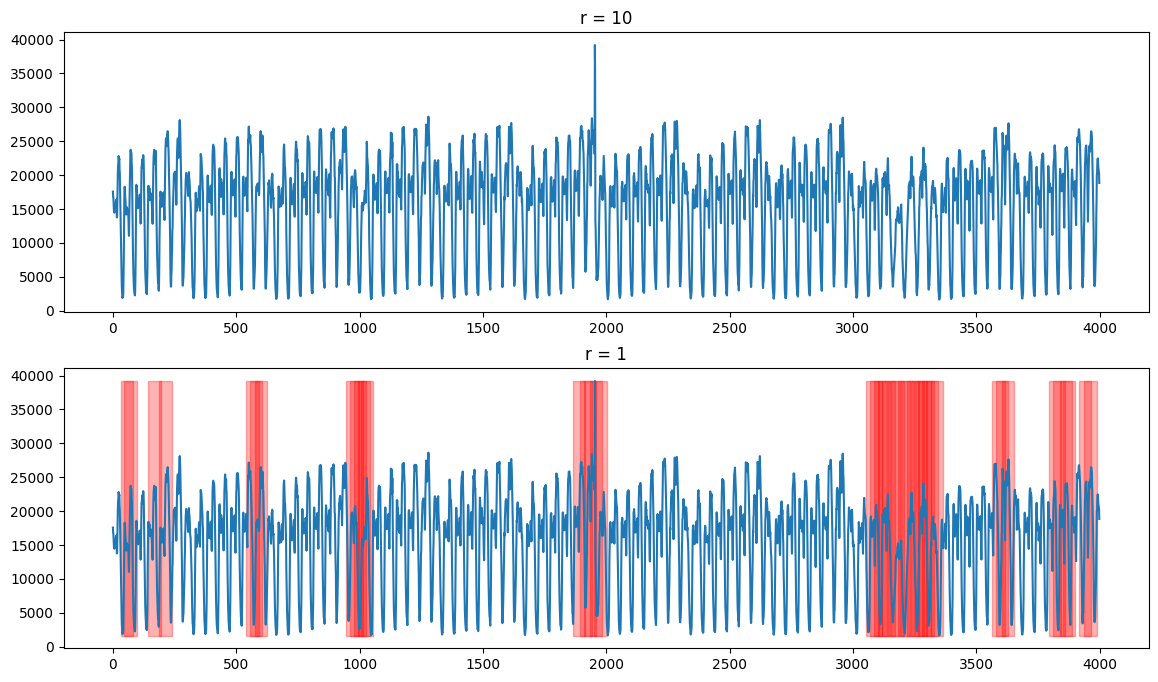

In [48]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
ax1.set_title('r = 10')
ax2.set_title('r = 1')
mn, mx = min(nyc_taxi), max(nyc_taxi)

for i in range(len(idxs_r_10)):
    alpha = 0.3
    ax1.add_patch(Rectangle(xy=(idxs_r_10[i], mn), width=size_sub, height=mx-mn, color='blue', alpha=alpha))
ax1.plot(nyc_taxi)

for i in range(len(idxs_r_1)):
    alpha = 0.3
    ax2.add_patch(Rectangle(xy=(idxs_r_1[i], mn), width=size_sub, height=mx-mn, color='red', alpha=alpha))
ax2.plot(nyc_taxi)

Чтобы разобраться, почему так происходит и как работает данный алгоритм, ниже мы реализуем все этапы алгоритма DRAG.

Как мы помним из лекций алгоритм DRAG содержит два этапа:

1. Отбор - За одно сканирование ряда сформировать множество кандидатов в диссонансы.
2. Очистка - За одно сканирование ряда отбросить кандидатов, которые являются ложными диссонансами.

##### 3.2.1 Отбор кандидатов

Первым этапом обработки данных является отбор множества потенциальных кандидатов. Мы вибраем из всего множества подпоследовательностей ряда такие, для которых растояния до правых ближайших соседей больше параметра $r$.

In [49]:
#выбирем более реальное значение для порога
r = 3

In [50]:
T, M_T, Σ_T = core.preprocess(data, m)

# формируем массив длинной равной длине исходного ряда - m + 1,
# элемент массива является истинным в том случае,
# если подпоследовательность является потенциальным кандидатом
is_cands = find_candidates(T, m, M_T, Σ_T, r, init_cands=None, right=True)

# находим индексы потенциальных кандидатов
cand_index = np.flatnonzero(is_cands)


In [51]:
print(f'{len(cand_index)} {len(cand_index)/len(data)*100} %')

113 11.3 %


Во время отбора кандидатов нам удалось выделить около 113 подпоследовательностей(около 11.3%), которые мы бы могли назвать потенциальными диссонансами.
Это большой процент, который не может нас устраивать как конечный результат.
Если посмотреть на рисунок ниже, мы увидим, что большая часть потенциальных диссонансов расположена в районе смены активности.
К сожалению пресутсвуют и ложные диссонансы, которые случайным образом попали в данный список.

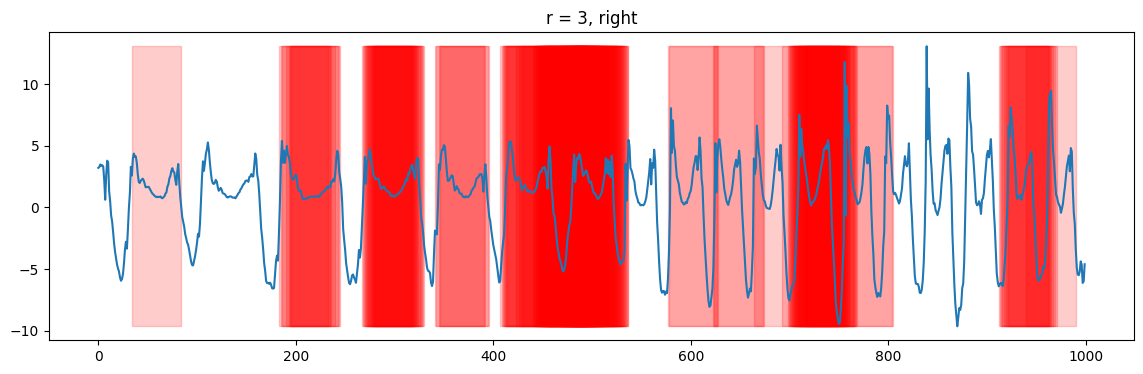

In [52]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.set_title('r = 3, right')
mn, mx = min(data), max(data)

for i in range(len(cand_index)):
    alpha = 0.2
    ax.add_patch(Rectangle(xy=(cand_index[i], mn), width=size_sub, height=mx-mn, color='red', alpha=alpha))
ax.plot(data)

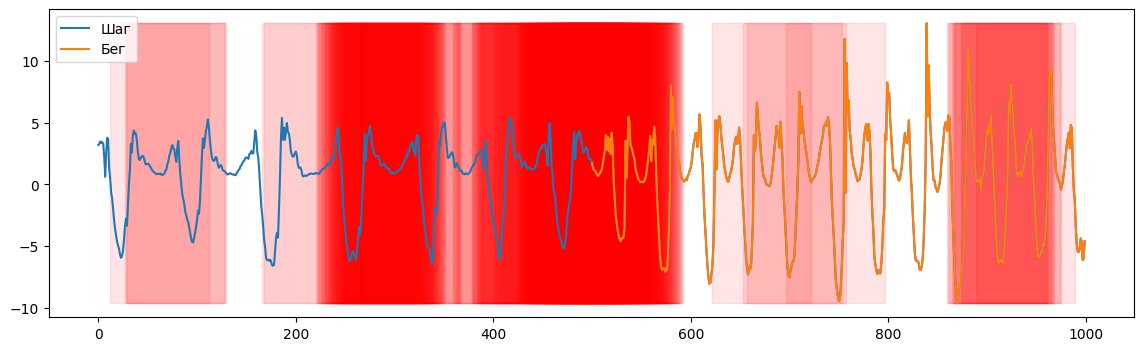

In [ ]:
"""fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(data[:],label='Шаг')
plt.plot(np.arange(data.shape[0]//2,data.shape[0]),data[data.shape[0]//2:],label='Бег')
max_ = np.max(data[:])
min_ = np.min(data[:])
for indx, discord in enumerate(cand_index):
    ax.add_patch(Rectangle((discord,min_),m,
                            max_+np.abs(min_),
                                                    color='red',
                                                    alpha=0.1))
plt.legend()


##### 3.2.2 Очистка кандидатов
Как уже упоминалось выше, 14% слишком большой процент диссонансов.
Для уменьшения числа потенциальных кандидатов произведем очистку от ложных диссонансов, путем сравнения расстояния до левых ближайших соседей потенциальных диссонансов с числом $r$.


In [53]:
is_cands = find_candidates(T, m, M_T, Σ_T, r, init_cands=is_cands, right=False)
cands = np.flatnonzero(is_cands)

In [54]:
len(cands)/len(data)*100

2.9000000000000004

Сформируйте график найденных диссонансов

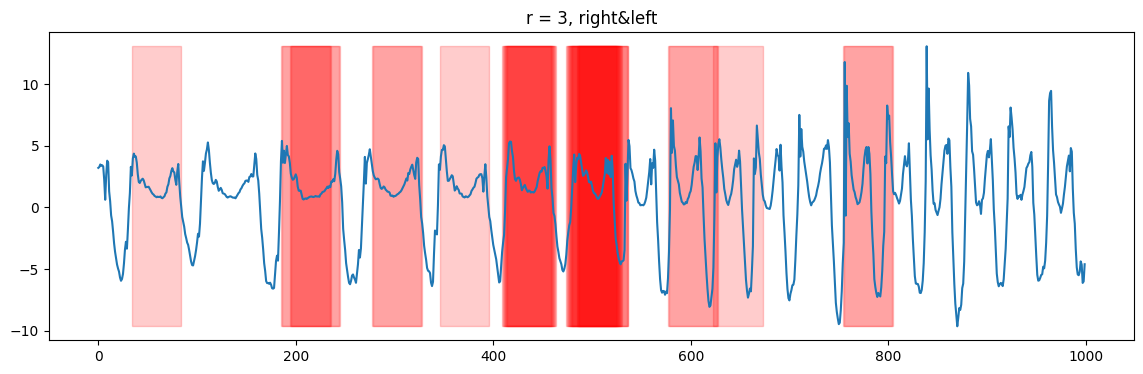

In [55]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.set_title('r = 3, right&left')
mn, mx = min(data), max(data)

for i in range(len(cands)):
    alpha = 0.2
    ax.add_patch(Rectangle(xy=(cands[i], mn), width=size_sub, height=mx-mn, color='red', alpha=alpha))
ax.plot(data)

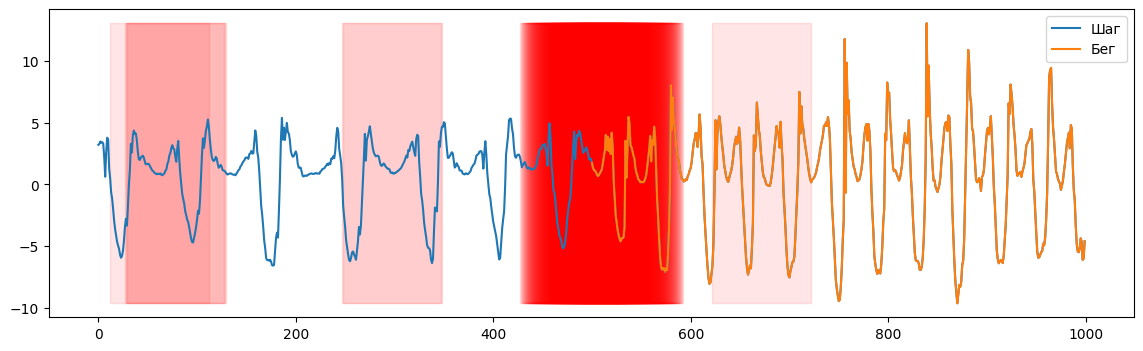

In [ ]:
"""fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(data[:],label='Шаг')
plt.plot(np.arange(data.shape[0]//2,data.shape[0]),data[data.shape[0]//2:],label='Бег')
max_ = np.max(data[:])
min_ = np.min(data[:])
for indx, discord in enumerate(cands):
    ax.add_patch(Rectangle((discord,min_),m,
                            max_+np.abs(min_),
                                                    color='red',
                                                    alpha=0.1))
plt.legend()


Нам удалось сократить число диссонансов до 7%. Если проанализировать рисунок, то можно заметить, что большая их часть является тривиальными повторениями подпоследовательности в области смены активности. На следующем шаге избавимся от них.

In [57]:
#from modules.drag import refine_candidates
discords_idx, discords_dist, discords_nn_idx = refine_candidates(T, m, M_T, Σ_T, is_cands)
len(discords_idx)/len(data)*100

0.8999999999999999

Сформируйте график найденных диссонансов

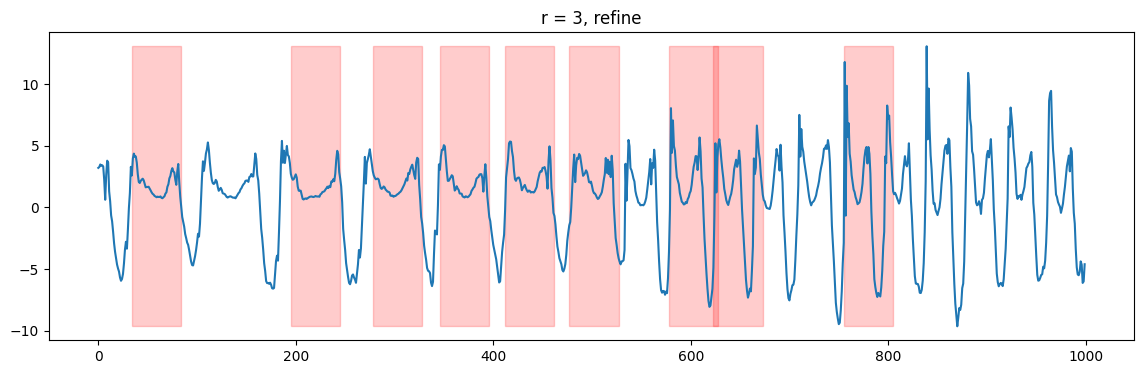

In [58]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.set_title('r = 3, refine')
mn, mx = min(data), max(data)

for i in range(len(discords_idx)):
    alpha = 0.2
    ax.add_patch(Rectangle(xy=(discords_idx[i], mn), width=size_sub, height=mx-mn, color='red', alpha=alpha))
ax.plot(data)

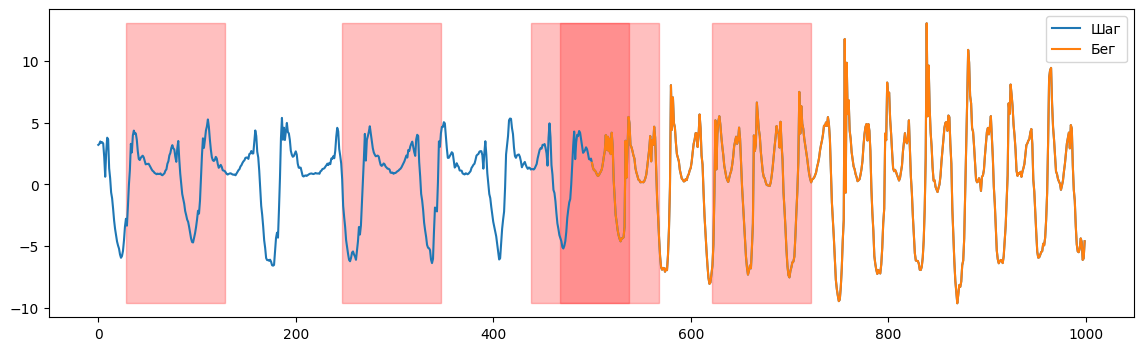

In [ ]:
"""fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(data[:],label='Шаг')
plt.plot(np.arange(data.shape[0]//2,data.shape[0]),data[data.shape[0]//2:],label='Бег')
max_ = np.max(data[:])
min_ = np.min(data[:])
for indx, discord in enumerate(discords_idx):
    ax.add_patch(Rectangle((discord,min_),m,
                            max_+np.abs(min_),
                                                    color='red',
                                                    alpha=0.25))
plt.legend()


##### 3.2.3 Подбор параметров

Реализуйте перебор параметров $m$ и $r$. Подберете параметры таким образом, чтобы алгоритм обнаружил только те диссонансы, которые связаны со сменой активности.

In [59]:
m_vals = [30, 35, 40, 45, 50, 55, 60]
r_vals = [2.5, 3, 3.5]

idxs = []
dists = []
nn_idxs = []

for m in m_vals:
    for r in r_vals:
        T, M_T, Σ_T = core.preprocess(data, m)
        is_cands = find_candidates(T, m, M_T, Σ_T, r, init_cands=None, right=True)
        is_cands = find_candidates(T, m, M_T, Σ_T, r, init_cands=is_cands, right=False)
        discords_idx, discords_dist, discords_nn_idx = refine_candidates(T, m, M_T, Σ_T, is_cands)

        idxs.append(discords_idx)
        dists.append(discords_dist)
        nn_idxs.append(discords_nn_idx)

        print(f'Done: m={m}, r={r}')

Done: m=30, r=2.5
Done: m=30, r=3
Done: m=30, r=3.5
Done: m=35, r=2.5
Done: m=35, r=3
Done: m=35, r=3.5
Done: m=40, r=2.5
Done: m=40, r=3
Done: m=40, r=3.5
Done: m=45, r=2.5
Done: m=45, r=3
Done: m=45, r=3.5
Done: m=50, r=2.5
Done: m=50, r=3
Done: m=50, r=3.5
Done: m=55, r=2.5
Done: m=55, r=3
Done: m=55, r=3.5
Done: m=60, r=2.5
Done: m=60, r=3
Done: m=60, r=3.5


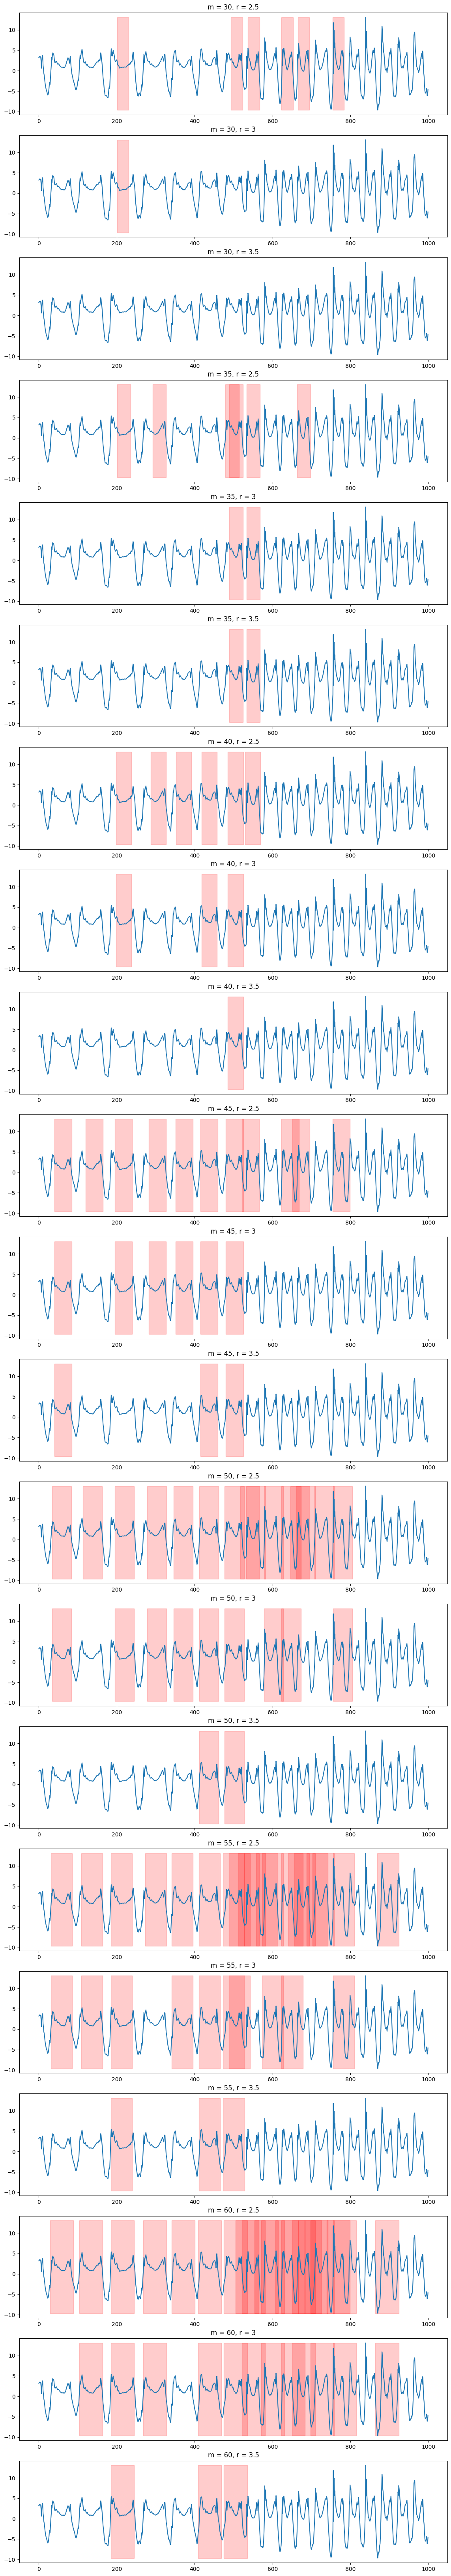

In [60]:
n = len(m_vals)*len(r_vals)
mn, mx = min(data), max(data)
fig, axs = plt.subplots(n, 1, figsize=(14, 4*n))

for j in range(n):
    axs[j].set_title(f'm = {m_vals[j//len(r_vals)]}, r = {r_vals[j%len(r_vals)]}')

    for i in range(len(idxs[j])):
        alpha = 0.2
        axs[j].add_patch(Rectangle(xy=(idxs[j][i], mn), width=m_vals[j//len(r_vals)], height=mx-mn, color='red', alpha=alpha))
    axs[j].plot(data)

#### **3.3 Поиск диссонансов с помощью алгоритма Merlin**

Как мы уже выяснили подбирать параметры для DRAG простым перебором не очень удобно. Для оптимизации данного процесса в статье [1] был предложен алгоритм Merlin для оптимального поиска подходящего порогового значения.

Условно мы можем разделить поиск диссонансов на три шага:

Поиск диссонансов минимальной длинны
. На данном шаге
.
Поиск диссонансов следующих четырех длин. На данном шаге
. Где
 - расстояние до ближайшего соседа предыдущего найденного диссонанса.
Поиск диссонансов всех
оставшихся дли.
. Средние значение и стандартное отклонение вычисляются из расстояний 5 предыдущих диссонансов. н

[1] Nakamura T., Imamura M., Mercer R., Keogh E.J. MERLIN: parameter-free discovery of arbitrary length anomalies in massive time series archives. 20th IEEE Int. Conf. on Data Mining, ICDM 2020, Sorrento, Italy, November 17-20, 2020. pp. 1190-1195. IEEE (2020). https://doi.org/10.1109/ICDM50108.2020.00147


##### 3.3.1 Загрузка и подготовка данных
fixme: добавить описание данных и саму выгрузку данных

##### 2.3.2 Merlin

Используя [реализацию]() найдите топ 5 диссонансов ряда.
Произведите замер времени работы. (уточнить про реализацию поиска соседей)

25

4

##### 2.3.3 Визаулизация

Вам необходимо реализовать код позволяющий:
1. Вывести на одном графике ряд и его диссонансы
2. Графики времени работы
   
Постройте графики для моделей и сравните полученные результаты с алгоритмами из предыдущих пунктов.
Сделайте выводы